In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable
import pylab as plt
import matplotlib.mlab as mlab
#log_pX = - beta1 * abs(X) - beta2 * X * X

def est_psd(lst,d):
    S = len(lst)
    for s in range(S):
        x = lst[s]
        hatx = torch.rfft(x ,1 ,onesided=False)
        amp2 = hatx[:,0]*hatx[:,0]+hatx[:,1]*hatx[:,1]
        if s==0:
            psd = amp2/d
        else:
            psd = psd + amp2/d
    psd = psd/S
    return psd

def mcmc_simulate_beta(Y_0 ,langevin_step_size ,langevin_step_num, image_size, beta1, beta2, samplestep = 100):
    #Y_tau = Y_0
    Y_tau = Y_0.clone().requires_grad_(True)
    lst_ytau = []
    for i in range(langevin_step_num):
        if Y_tau.grad is not None:
            Y_tau.grad.data.zero_()
        #Y_tau = Variable(Y_tau, requires_grad=True)
        noise = torch.randn(image_size)
        if i % samplestep == 0:
            lst_ytau.append(Y_tau)
        log_pY = (- beta1 * abs(Y_tau) - beta2 * Y_tau ** 2).sum()
        log_pY.backward()
        #print(i, Y_tau, noise, Y_tau.grad)
        #Y_tau = Y_tau + 0.5 * langevin_step_size * langevin_step_size * \
        #(Y_tau.grad) + langevin_step_size * noise
        Y_diff = 0.5 * (langevin_step_size**2)*Y_tau.grad + langevin_step_size * noise
        #print(i, Y_tau.grad.norm()) # Y_tau, noise, Y_tau.grad)
        Y_tau.data.add_(Y_diff.data)
        #print(Y_tau)
    #print(lst_ytau)
    for s in range(len(lst_ytau)):
        x = lst_ytau[s]
        Y_tau = Y_tau + x
    Y_tau = Y_tau / (len(lst_ytau) + 1)
    return Y_tau.data.numpy(),lst_ytau

langevin_step_size = 0.01 
langevin_step_num = 200000
image_size = 128
beta1 = 2
beta2 = 0
Y_0 = torch.randn(image_size)
Y_u0 = torch.rand(image_size)
Y_u = torch.ones(image_size)


Y_o,lst_ytau = mcmc_simulate_beta(Y_u ,langevin_step_size ,langevin_step_num, image_size, beta1, beta2)
print(Y_o)
psd_ytau = est_psd(lst_ytau,image_size)
plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(psd_ytau.data.numpy())
plt.title('ytau psd')

plt.subplot(412)
plt.psd(Y_o, NFFT=150, Fs=100000, window=mlab.window_none, pad_to=512, noverlap=75,
        scale_by_freq=True)

[-0.3677938  -0.02889635  0.08067806  1.1122836   0.6293951   0.19135524
  0.38325527 -0.52801245 -0.3608846   0.23728038  0.03333351 -0.16518205
  0.606282    0.4608163  -0.07239623 -0.00958713 -0.1787694  -0.03228303
  0.00371682 -0.29122427 -0.63245803 -1.2676578   1.1215838   0.5100593
 -0.67554796 -0.06100461 -0.22170143 -0.9411642   0.03906504 -0.13145511
 -0.03800218  0.09565734 -1.110345   -0.29278427  0.01122144 -0.06818209
 -1.1343048  -1.1239192   0.20400941  1.7829064   0.26772755 -0.07771429
 -1.1583056  -0.5484611  -0.15266725  1.2736766  -0.01533137 -1.3467678
 -0.36346972 -0.07116839  0.00217818  0.31559306 -0.00560858  0.27022466
  0.45057452  1.6190791   0.01897814  0.39202383  0.7238421  -0.42022675
  0.05142963  0.353337   -0.17019722  0.6101885  -0.3909151  -0.30572352
  0.21283862 -0.20616777  1.609058   -0.52118057 -0.12423726 -0.06515644
 -0.8883035  -0.33256286 -0.49609062  0.14416838  2.0434713   0.26285443
  0.20142567  0.15667973 -1.9575707  -0.6358244  -0.0

(array([1.73857217e-07, 8.48074365e-07, 2.03697414e-06, 2.68814051e-06,
        1.52821758e-06, 3.90246271e-08, 2.90032494e-06, 1.29618475e-05,
        2.59938897e-05, 3.30235744e-05, 2.88845949e-05, 1.71348674e-05,
        5.96964765e-06, 6.09522772e-07, 3.23571726e-07, 1.37002849e-06,
        1.24739336e-06, 3.17309684e-07, 3.25180366e-07, 1.78661685e-06,
        3.10365817e-06, 2.60898196e-06, 9.05835691e-07, 4.83675677e-09,
        5.01944726e-07, 1.47268372e-06, 3.31995352e-06, 8.16178363e-06,
        1.58728562e-05, 2.18752793e-05, 2.13812000e-05, 1.49257485e-05,
        7.50400841e-06, 2.90415869e-06, 1.12950647e-06, 8.94045058e-07,
        1.95302550e-06, 4.46085323e-06, 7.96591667e-06, 1.15496287e-05,
        1.36816989e-05, 1.23855052e-05, 7.51969037e-06, 2.32852062e-06,
        1.46445515e-07, 1.88017253e-07, 4.85026952e-08, 1.66555913e-06,
        9.25324366e-06, 2.00932755e-05, 2.41000362e-05, 1.70491548e-05,
        8.67031576e-06, 1.07135993e-05, 2.04203698e-05, 2.407866

In [5]:
Eabsy=abs(Y_o).sum()/image_size
Ey2=(Y_o ** 2).sum()/image_size
print(Eabsy,Ey2)

kk = image_size
Y_u0 = np.random.rand(kk)
Y_o2 = - 1/beta1*np.log(1-Y_u0)
Eabsyo=abs(Y_o2).sum()/kk
Eyo2=(Y_o2 ** 2).sum()/kk
print(Eabsyo,Eyo2)

0.4852299690246582 0.4748646914958954
0.46290381862256746 0.5047388474054497


[ 1.1352289  -0.04129035 -1.5735627  -0.9793948   0.9869834  -0.8308791
 -0.57025254  0.947448    0.07530025 -1.6588609   0.29689974  0.4359636
  0.8394519   0.94712144  0.4692241   1.0679188   0.3040223  -2.6343186
 -1.4466689  -0.16410415 -0.3488305   0.05285299  1.094947    0.6887619
  0.6878239   0.90692437 -0.93525916 -0.6357416  -2.3455913  -1.0530258
 -0.12102371  0.6028716  -1.021735    1.4097571   0.00930649  0.2002309
  0.15560374  1.0728078   1.4920273   1.1001496  -0.65878785  1.0051582
 -0.04894441 -0.47880533  0.44882426 -0.6536855   1.2918048  -1.0834328
  0.53328615  0.500036   -1.0952569   0.5823646  -0.50173163 -0.07449207
 -0.41174096  0.48761228  0.27634782 -0.18677926 -1.5910332   0.3273113
 -0.48557162 -1.6426337   0.10873586 -1.2276459   0.42587298 -1.8894753
 -0.20564964 -0.91215366 -0.6086152   1.4261544  -0.58008844 -1.8170786
  1.113781    0.5052225   0.8485058  -1.0383483   0.5046612   1.3977178
  0.6838651  -0.45851892 -1.28945     0.5384996  -0.00433911  1

(array([1.27592932e-06, 5.61410161e-06, 1.09928724e-05, 1.29328691e-05,
        1.16882402e-05, 1.14265285e-05, 1.24115259e-05, 1.08378754e-05,
        6.56353950e-06, 5.74658907e-06, 1.34952461e-05, 2.70788041e-05,
        3.84580926e-05, 4.11463770e-05, 3.35443729e-05, 1.93349970e-05,
        6.90544994e-06, 4.14139095e-06, 9.67676715e-06, 1.27959584e-05,
        7.08539983e-06, 7.01003785e-07, 5.71734154e-06, 1.93253181e-05,
        2.54157439e-05, 1.63928544e-05, 3.45676517e-06, 5.33122204e-07,
        7.18976253e-06, 1.47826013e-05, 2.10387152e-05, 2.76568881e-05,
        2.94157344e-05, 1.97362988e-05, 5.80338292e-06, 3.57480417e-06,
        1.48116787e-05, 2.29269681e-05, 1.80385687e-05, 1.28056918e-05,
        2.21131759e-05, 3.74400042e-05, 3.74494557e-05, 2.02021947e-05,
        7.82685856e-06, 1.59017218e-05, 3.22070118e-05, 3.42117855e-05,
        1.89499697e-05, 5.17175840e-06, 8.47925548e-06, 2.31801987e-05,
        3.07910559e-05, 2.18037439e-05, 5.74083788e-06, 4.131495

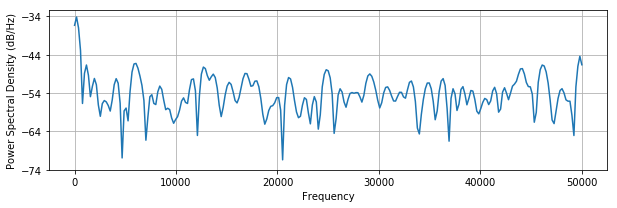

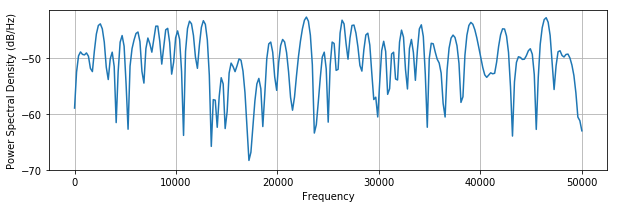

In [6]:
sigma = 1
Y_data_gauss = sigma * torch.randn(image_size).numpy()
print(Y_data_gauss)
print(abs(Y_data_gauss).sum()/image_size,(Y_data_gauss ** 2).sum()/image_size)

def mle_simulate_beta(Y_data, Y_tuta0, beta1_0, beta2_0, mle_step_num, mle_step_size,langevin_step_size, langevin_step_num, image_size):
    beta1 = beta1_0
    beta2 = beta2_0
    Y_tuta = Y_tuta0
    for i in range(mle_step_num):
        Y_tuta,_ = mcmc_simulate_beta(torch.Tensor(Y_tuta), langevin_step_size, langevin_step_num, image_size, beta1, beta2)
        #Y_tuta = mcmc_simulate_beta(Y_tuta0, langevin_step_size, langevin_step_num, image_size, beta1, beta2)
        d_beta1 = ((-abs(Y_data).sum()) - (-abs(Y_tuta).sum())) / image_size
        d_beta2 = ((-(Y_data ** 2).sum()) - (-(Y_tuta ** 2).sum())) / image_size
        beta1 = beta1 + mle_step_size * d_beta1
        beta2 = beta2 + mle_step_size * d_beta2
        if(beta1<0):
            beta1 = 0
        if(beta2<0):
            beta2 = 0
        print(beta1,beta2)
        #print(i,Y_tuta)
    return beta1,beta2

import pylab as plt
import matplotlib.mlab as mlab
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.psd(Y_o2, NFFT=150, Fs=100000, window=mlab.window_none, pad_to=512, noverlap=75,
        scale_by_freq=True)

plt.figure(figsize=(10,10))
plt.subplot(312)
plt.psd(Y_data_gauss, NFFT=150, Fs=100000, window=mlab.window_none, pad_to=512, noverlap=75,
        scale_by_freq=True)

In [ ]:
Y_tuta0 = torch.randn(image_size)
beta1_0 = 0.1
beta2_0 = 0.6
mle_step_num = 1000
mle_step_size = 0.01
#langevin_step_num = 1000
#beta1_o,beta2_o = mle_simulate_beta(Y_o, Y_tuta0, beta1_0, beta2_0, mle_step_num, mle_step_size,langevin_step_size, langevin_step_num, image_size)
beta1_o,beta2_o = mle_simulate_beta(Y_data_gauss, Y_tuta0, beta1_0, beta2_0, mle_step_num, mle_step_size,langevin_step_size, langevin_step_num, image_size)
print(beta1_o,beta2_o)

In [8]:
Y_tuta0 = torch.randn(image_size)
beta1_0 = 1.9
beta2_0 = 0.
mle_step_num = 1000
mle_step_size = 0.1
langevin_step_num = 30000
beta1_o,beta2_o = mle_simulate_beta(Y_o, Y_tuta0, beta1_0, beta2_0, mle_step_num, mle_step_size,langevin_step_size, langevin_step_num, image_size)
#beta1_o,beta2_o = mle_simulate_beta(Y_data_gauss, Y_tuta0, beta1_0, beta2_0, mle_step_num, mle_step_size,langevin_step_size, langevin_step_num, image_size)
print(beta1_o,beta2_o)

1.9107106804847716 0.017178502678871155
1.9086146116256713 0.014787152409553528
1.9090186297893523 0.013461321592330933
1.9199110984802246 0.03486070334911347
1.9164745002985 0.030170729756355288
1.9141260176897048 0.0237440824508667
1.9162897616624832 0.02941718399524689
1.920418593287468 0.03646759986877442
1.9211814492940904 0.03927265703678132
1.9230051904916765 0.03327086865901947
1.9240433782339097 0.03139606714248658
1.923869776725769 0.028372865915298466
1.9271645247936249 0.036032691597938545
1.9273184418678284 0.040338736772537236
1.9256294906139375 0.032042270898818975
1.9208543241024019 0.02048650681972504
1.9240411579608918 0.027566623687744145
1.9213137447834017 0.02127500474452973
1.9237230718135836 0.02387493252754212
1.930812430381775 0.041373309493064885
1.9368798673152925 0.04931055307388306
1.9350284308195116 0.04273245632648468
1.9362771332263948 0.039421582221984865
1.9422915935516358 0.05040188133716583
1.951951289176941 0.0678751826286316
1.949071753025055 0.065

2.0459025770425785 0.014826482534408568
2.0483379751443853 0.015820929408073423
2.050324025750159 0.024170249700546265
2.0478122502565372 0.0146730899810791
2.0525493055582036 0.021502169966697692
2.0532860457897177 0.021415406465530393
2.0590042412281027 0.03284668624401092
2.0604446202516544 0.03440185189247131
2.063993462920188 0.03904305398464202
2.062926736474036 0.040232920646667475
2.062464424967765 0.03486193716526031
2.0624842792749396 0.03622565269470214
2.0583085626363746 0.022127634286880485
2.0584997266530984 0.02110992968082427
2.0582870066165917 0.022099846601486197
2.0561428844928735 0.013533985614776601
2.0541641592979425 0.009392240643501273
2.0595066189765925 0.020661962032318106
2.0546713232994076 0.00587538182735442
2.058092004060745 0.007372519373893727
2.0590389072895046 0.012758994102478017
2.053606671094894 0.0032105356454849125
2.051158499717712 0
2.048672884702682 0
2.049101877212524 0.004442086815834046
2.0537104666233055 0.023854863643646244
2.0492836296558

2.040088477730751 0.037324199080467226
2.0329104542732237 0.027004307508468627
2.032764649391174 0.023063501715660094
2.0369259357452387 0.030175101757049558
2.0389881730079646 0.031821992993354795
2.0411238729953762 0.031974279880523676
2.041954609751701 0.03334543108940124
2.043280896544456 0.03653436601161956
2.0400175422430036 0.02745128571987151
2.032527312636375 0.011452355980873095
2.0337375104427333 0.008664822578430164
2.0321771174669263 0.0025758326053619265
2.027040886878967 0
2.0341529965400693 0.015106013417243958
2.0346080809831615 0.009638616442680359
2.0350320160388944 0.002747383713722228
2.037610328197479 0.00930662155151367
2.032596695423126 0
2.0368318796157836 0.009485653042793274
2.0416852116584776 0.013017767667770387
2.0379700005054473 0.007489570975303651
2.047557032108307 0.03397486805915833
2.0457066237926482 0.03948357999324799
2.0475516855716704 0.04633746147155762
2.0496029913425446 0.04886192977428437
2.0418292820453643 0.035303896665573126
2.039252173900

2.01540361046791 0
2.011939299106597 0
2.0111740410327905 0
2.0021496534347527 0
1.998523196578025 0
1.9991170257329933 0
2.0000769406557075 0.0008164703845977783
1.9929599255323402 0
1.9960992306470864 0.00897691547870636
1.9985106557607644 0.01404516100883484
2.0054561287164683 0.02527941167354584
2.0117611140012737 0.035945892333984375
2.010421201586723 0.032959914207458495
2.012974527478218 0.042077353596687316
2.0179526835680006 0.04358293414115905
2.0191057711839675 0.03880208432674408
2.029718908667564 0.06879041194915772
2.029875567555427 0.08172525465488434
2.02257732450962 0.06595390439033508
2.0227137655019756 0.060027828812599174
2.0150699377059933 0.044793963432312005
2.0157657384872434 0.042693018913269036
2.0157947182655334 0.04291539788246154
2.015642750263214 0.03744204342365264
2.012958115339279 0.029163822531700127
2.0128213733434674 0.033373612165451046
2.0197970718145366 0.04274742901325226
2.0184342443943017 0.038743576407432555
2.013646918535232 0.031952852010726

2.0429873585700995 0.012931555509567264
2.0414238274097447 0.009749111533164982
2.040982103347779 0.0045929819345474285
2.038494539260865 0
2.0458257794380192 0.014731338620185852
2.037741765379906 0.0005181193351745609
2.0353953748941427 0
2.037565496563912 0.0024971961975097656
2.0339130431413657 0
2.029868024587632 0
2.0334289014339455 0.008278921246528625
2.0342452973127374 0.01080126166343689
2.0315602093935023 0.002773568034172058
2.0282869786024103 0
2.0339370161294945 0.011005547642707825
2.0392117887735375 0.018443220853805543
2.0412283688783655 0.02017141878604889
2.040169271826745 0.017400985956192015
2.0396644711494454 0.012314838171005246
2.0311677008867273 0
2.036869224905969 0.017251530289649965
2.0402355164289485 0.02950918674468994
2.052886959910394 0.04873529970645905
2.047981187701226 0.05139489769935608
2.0456433236598976 0.04345111548900604
2.0420037269592295 0.03257899880409241
2.043761575222016 0.027516824007034302
2.0469301640987405 0.037062075734138486
2.040848